In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import geopandas as gpd
import geoplot
import descartes
from shapely.geometry import Point, Polygon
import seaborn as sns

In [3]:
df = pd.read_csv('Documents/Thesis/data.csv')
print(df['index'].count())
df.describe()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,4,5,6,9,10,13,14,15,17,19,25,37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


295142


,perfectMatches,presentPrice,price,streetNumber,beds,baths,advertisedPrice,area.2,beds.1,baths.1,ber.1,dateEntered.1,agency.1,advertisedPrice.1,propertyType.1
count,0.0,2.623920e+05,2.951170e+05,173157.000000,101726.000000,96262.000000,1.030500e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,2.710720e+05,2.337288e+05,43.501291,3.159418,1.971422,2.432580e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,6.077579e+05,4.771393e+05,124.256794,0.993405,0.961807,2.116650e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,3.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,6.000000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.175300e+05,1.000000e+05,9.000000,3.000000,1.000000,1.300000e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2.026900e+05,1.750000e+05,22.000000,3.000000,2.000000,1.989500e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,3.248240e+05,2.800000e+05,48.000000,4.000000,3.000000,2.950000e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,9.972622e+07,8.636500e+07,14100.000000,23.000000,12.000000,1.500000e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.dropna(subset=['pricePerSqrMetres', 'beds', 'baths']) #drop all entries with no SQM info
pd.to_numeric(df["pricePerSqrMetres"], errors='coerce') #force few string values into NAN using errors='coerce'
df['year'] = df['saleDate'].str[:4]

#convert some variables to numeric
df["beds"] = pd.to_numeric(df["beds"], errors='coerce')
df["baths"] = pd.to_numeric(df["baths"], errors='coerce')
df["price"] = pd.to_numeric(df["price"], errors='coerce')
df["latitude"] = pd.to_numeric(df["latitude"])
df["longitude"] = pd.to_numeric(df["longitude"])
print(df['baths'].isna().sum())

#drop duplicate or not useful columns
df = df.drop(columns=['streetNumber', 'declaredCounty', 'area','daftProperty','daftdropProperty','inconsistentAddress',
                     'perfectMatches','fixedAddress','geoCodeApiTried','geocodePrecision','hasPerfectMatch','noVatPrice',
                     'notFullMarketPrice','area.2','beds.1','baths.1','ber.1', 'dateEntered.1', 'agency.1',
                      'advertisedPrice.1', 'propertyType.1','vATExclusive','dateEntered','type','index','daysToSell',
                     'location','presentPrice','propertySizeDescription']) #drop unneeded columns
print(df['price'].isna().sum())
print(df['price'].head())

0
0
676      123500.0
1553     110000.0
10190    149000.0
10506    210000.0
12514     50000.0
Name: price, dtype: float64


In [5]:
#create square metre variable
df['sqm'] = pd.to_numeric(df["price"]) / pd.to_numeric(df["pricePerSqrMetres"])
print(df['sqm'].describe())
print(df.count())

df = df[df['sqm'] < 500] #remove some outliers
df = df[df['sqm'] > 20]

#store log price/sqm
df['log_price'] = np.log(df['price'])
df['log_sqm'] = np.log(df['sqm'])

count    13043.000000
mean       118.041556
std         73.616452
min          0.092900
25%         80.000000
50%        103.000000
75%        134.700000
max       1485.000000
Name: sqm, dtype: float64
county                 13043
houseNoStreet          13043
id                     13043
latitude               13043
longitude              13043
neighborhood            8840
postalCode              9061
price                  13043
pricePerSqrMetres      13043
propertyDescription    13043
rawAddress             13043
region                 11860
saleDate               13043
street                 11457
area.1                 12961
beds                   13043
baths                  13043
ber                     5247
agency                 13021
advertisedPrice        13039
propertyType           11800
year                   13043
sqm                    13043
dtype: int64


In [6]:
#format dates
df['date_format'] = df['saleDate'].str[:10]
df['Date']= pd.to_datetime(df['date_format'])
df['duration'] = ((df['Date'] - df['Date'].min())/np.timedelta64(1, 'M'))
df['duration'] = df['duration'].astype(int)

In [7]:
#convert dublin codes to 3 letters for consistency eircode format
#didnt end up using this.. post code isnt that useful when you know geocodes
df['postalCode'] = df['postalCode'].replace("Dublin 1", "D01")
df['postalCode'] = df['postalCode'].replace("Dublin 2", "D02")
df['postalCode'] = df['postalCode'].replace("Dublin 3", "D03")
df['postalCode'] = df['postalCode'].replace("Dublin 4", "D04")
df['postalCode'] = df['postalCode'].replace("Dublin 5", "D05")
df['postalCode'] = df['postalCode'].replace("Dublin 6", "D06")
df['postalCode'] = df['postalCode'].replace("Dublin 7", "D07")
df['postalCode'] = df['postalCode'].replace("Dublin 8", "D08")
df['postalCode'] = df['postalCode'].replace("Dublin 9", "D09")
df['postalCode'] = df['postalCode'].replace("Dublin 10", "D10")
df['postalCode'] = df['postalCode'].replace("Dublin 11", "D11")
df['postalCode'] = df['postalCode'].replace("Dublin 12", "D12")
df['postalCode'] = df['postalCode'].replace("Dublin 13", "D13")
df['postalCode'] = df['postalCode'].replace("Dublin 14", "D14")
df['postalCode'] = df['postalCode'].replace("Dublin 15", "D15")
df['postalCode'] = df['postalCode'].replace("Dublin 16", "D16")
df['postalCode'] = df['postalCode'].replace("Dublin 17", "D17")
df['postalCode'] = df['postalCode'].replace("Dublin 18", "D18")
df['postalCode'] = df['postalCode'].replace("Dublin 19", "D19")
df['postalCode'] = df['postalCode'].replace("Dublin 20", "D20")
df['postalCode'] = df['postalCode'].replace("Dublin 21", "D21")
df['postalCode'] = df['postalCode'].replace("Dublin 22", "D22")
df['postalCode'] = df['postalCode'].replace("Dublin 23", "D23")
df['postalCode'] = df['postalCode'].replace("Dublin 24", "D24")
df['postalCode'] = df['postalCode'].str[:3]
df.postalCode.value_counts().head(30) #3928 NaN values

D15    470
D18    342
T12    278
D04    268
D09    268
D07    260
D14    243
D16    241
D08    235
D13    234
D03    228
A94    225
V94    221
H91    220
D05    218
D24    208
D12    182
A96    181
D06    181
D11    172
K67    145
W91    145
A92    133
A63    128
X91    117
W23    117
C15    116
D01    112
K32    106
K78    104
Name: postalCode, dtype: int64

In [8]:
North_dub = df[df['postalCode'].isin(['D01', 'D03', 'D05', 'D07', 'D09', 'D11','D13', 'D15','D17', 'D19', 'D21', 'D23'])]
South_dub = df[df['postalCode'].isin(['D02', 'D04', 'D06', 'D08', 'D10', 'D12','D14', 'D16','D18', 'D20', 'D22', 'D24'])]
print(North_dub['price'].median())
print(South_dub['price'].median())
#South dublin has 63k higher median price 

317000.0
380000.0


In [9]:
#replace any postcodes with low frequency with "other" to reduce complexity in trees later
postcode_frequencies = df['postalCode'].value_counts()
postcode_low_freq = pd.DataFrame(postcode_frequencies)
postcode_low_freq.reset_index(level=0, inplace=True)
postcode_low_freq = postcode_low_freq.rename(columns={"index": "postalCode", "postalCode": "count"})
low_freq_codes = postcode_low_freq['postalCode'][postcode_low_freq['count'] < 10]
df['postalCode'].replace(np.array(low_freq_codes), 
           "Other", inplace=True) #replace function removes need for a for loop here
df.postalCode.value_counts().head(30)

D15      470
D18      342
T12      278
D09      268
D04      268
D07      260
D14      243
D16      241
D08      235
D13      234
D03      228
A94      225
V94      221
H91      220
D05      218
D24      208
D12      182
D06      181
A96      181
D11      172
W91      145
K67      145
Other    145
A92      133
A63      128
X91      117
W23      117
C15      116
D01      112
K32      106
Name: postalCode, dtype: int64

In [10]:
#drop out a bunch of errors & a few outliers
df = df.drop(df[(df.price < 500000) & (df.sqm > 400)].index)
df = df.drop(df[(df.price < 250000) & (df.sqm > 300)].index)
df = df.drop(df[(df.price < 125000) & (df.sqm > 200)].index)
df = df.drop(df[(df.price >= 1500000) & (df.price <= 95000)].index) 
df = df.drop(df[(df.sqm > 10000) & (df.sqm < 500)].index) 
#There are multiple apartments or very few with 10+ beds, baths -> remove these
df = df.drop(df[(df.baths >= 10) | (df.beds == 10)].index)
#wrong latitude
df = df.drop(df[df.latitude < 50].index)

#drop ids withs incorrect details or some commercial properties
ids_to_drop = [277735,226209,283736,244659,260940,260560,273372,236329
               ,246274,285390,240079,224972,246292,268393,244328,285829,216363,284209,
               264152,284027,273765,251664,283702,260824,260872,284320,227994,240878,
               265283,268879,229213]

df = df.drop(df[df.id.isin(ids_to_drop)].index)
df.describe()

,latitude,longitude,price,beds,baths,advertisedPrice,sqm,log_price,log_sqm,duration
count,12885.000000,12885.000000,1.288500e+04,12885.000000,12885.000000,1.288100e+04,12885.000000,12885.000000,12885.000000,12885.000000
mean,53.123341,-7.082320,3.163276e+05,3.119829,2.033450,3.119755e+05,113.948694,12.461667,4.647970,62.262553
std,0.596102,1.088117,2.377693e+05,0.995760,0.955815,2.365494e+05,52.073982,0.636500,0.411127,5.410262
min,51.478734,-10.431487,1.810000e+04,1.000000,1.000000,2.000000e+04,25.000000,9.803667,3.218876,0.000000
25%,52.854296,-8.209870,1.800000e+05,2.000000,1.000000,1.790000e+05,80.000000,12.100712,4.382027,59.000000
50%,53.299394,-6.412019,2.600000e+05,3.000000,2.000000,2.550000e+05,102.000000,12.468437,4.624973,63.000000
75%,53.387423,-6.239452,3.800000e+05,4.000000,3.000000,3.750000e+05,132.000000,12.847927,4.882802,66.000000
max,55.364700,-6.021483,3.675000e+06,9.000000,9.000000,3.700000e+06,488.000000,15.117064,6.190315,71.000000


<AxesSubplot:>

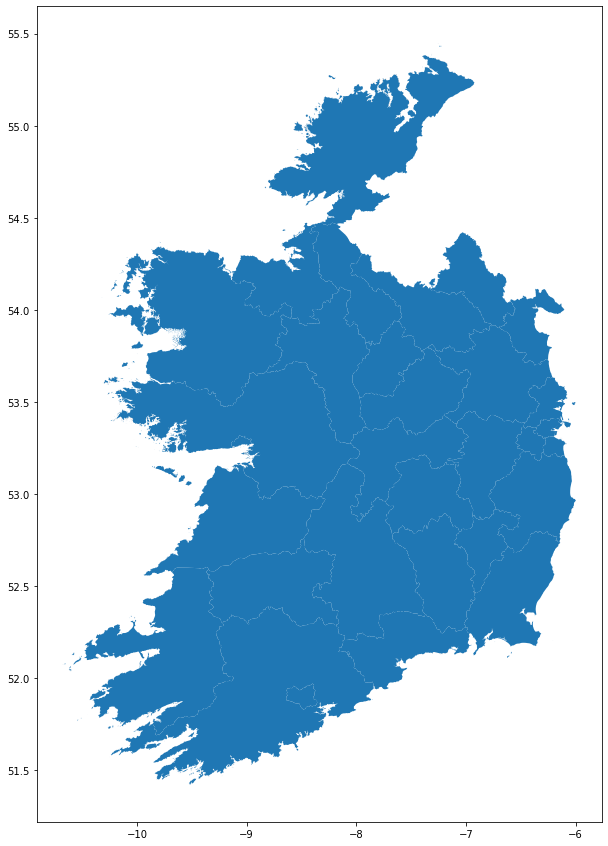

In [11]:
ireland = gpd.read_file('Documents/Thesis/Ireland_shapefile/opendata/0b3cbe50-ea67-467b-adb6-f3d9d3aaa43a2020329-1-f7bsff.bn1f.shx')
irl_shape_map_geo = ireland.to_crs(epsg=4326) #convert into lon/lat space from CRS (metres)
fig, ax = plt.subplots(figsize=(15,15))
irl_shape_map_geo.plot(ax=ax)

<AxesSubplot:>

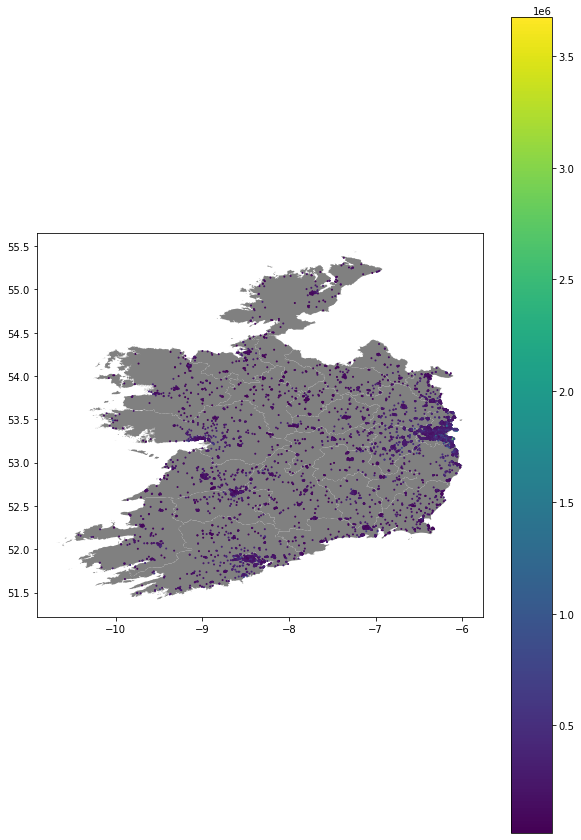

In [87]:
#plot prices on map
#hard to see because it is grouping houses <1m together. Trim dataset below
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
fig, ax = plt.subplots(figsize=(10, 15))
irl_shape_map_geo.plot(ax=ax, color='gray')
gdf.plot(ax=ax, column='price', markersize=1, legend=True) 

<AxesSubplot:>

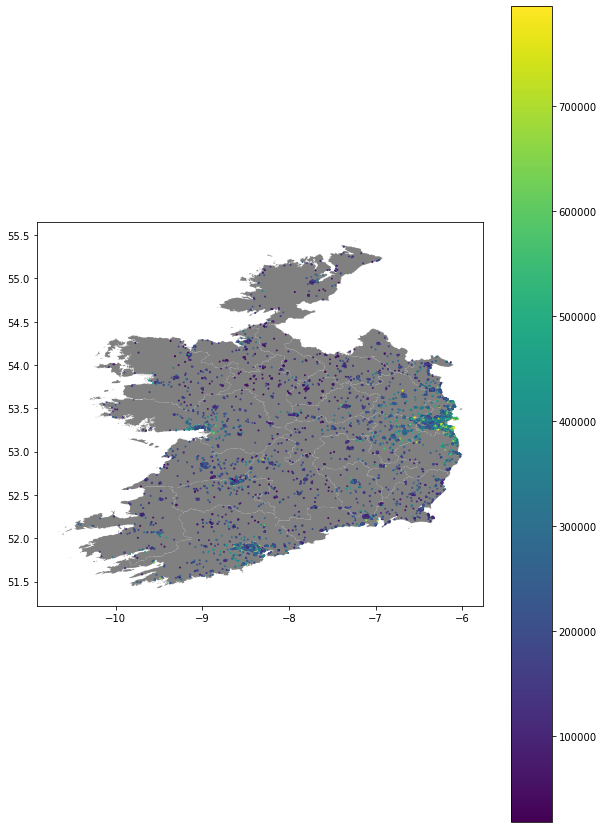

In [88]:
#cut out houses above 800k to make it easier to see price differences. 
#Not much green in the midlands!
df_trim = df[df['price'] < 800000]
gdf_trim = gpd.GeoDataFrame(df_trim, geometry=gpd.points_from_xy(df_trim.longitude, df_trim.latitude))
fig, ax = plt.subplots(figsize=(10, 15))
irl_shape_map_geo.plot(ax=ax, color='gray')
gdf_trim.plot(ax=ax, column='price', markersize=1, legend=True)

<AxesSubplot:ylabel='Frequency'>

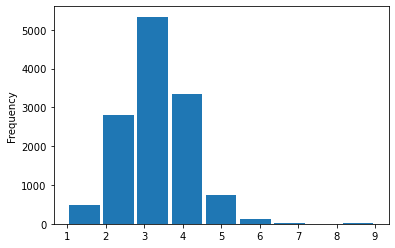

In [89]:
df['beds'].plot.hist(bins=9, rwidth=0.9)
#most places are 3 bedroom 

Text(0, 0.5, 'log price')

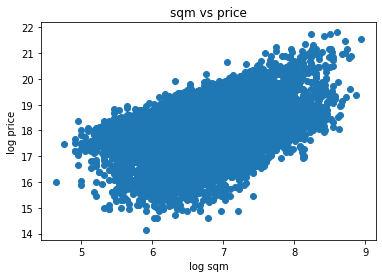

In [90]:
plt.scatter(np.log2(df['sqm']), np.log2(df['price']))
plt.title('sqm vs price')
plt.xlabel('log sqm')
plt.ylabel('log price')

<AxesSubplot:xlabel='Date'>

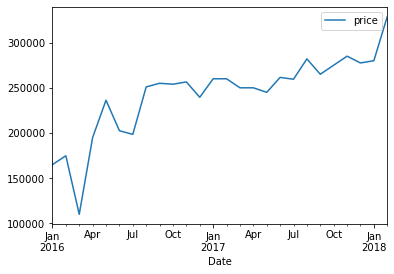

In [91]:
#calculate median monthly prices over time 
df_sorted = df.sort_values(by=['saleDate'])
df_sorted = df_sorted.drop(df_sorted[df_sorted.date_format < '2016-01-01'].index)
df_sorted = df_sorted[["Date", "price"]]
df_sorted.set_index('Date',inplace=True)
df_sorted = df_sorted.resample("M").median()
df_sorted.plot(y='price', use_index=True)
#can filter for dublin here and plot same 

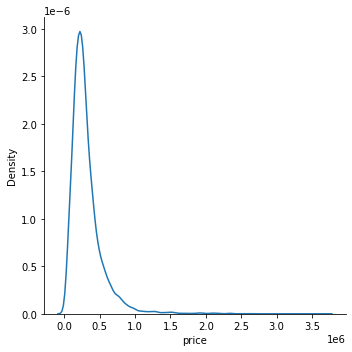

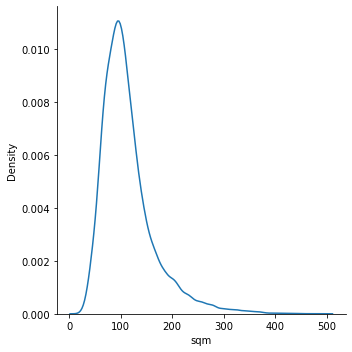

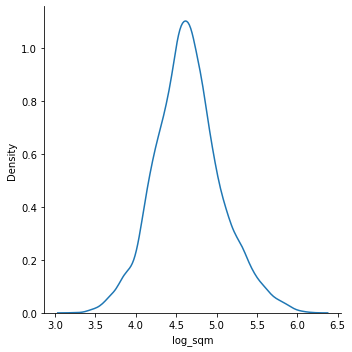

In [92]:
#density of price
sns.displot(df, x="price", kind="kde")
sns.displot(df, x="sqm", kind="kde")
sns.displot(df, x="log_sqm", kind="kde")

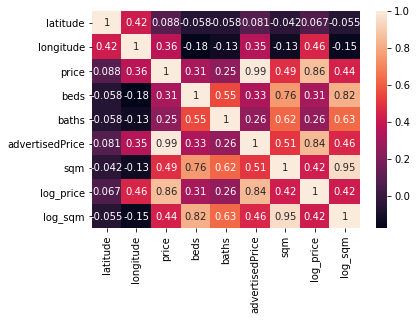

In [93]:
#correlation matrix for numeric variables
corrMatrix = df[df.columns[0:25]].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()
#intuitive.. beds correlated with sqm etc

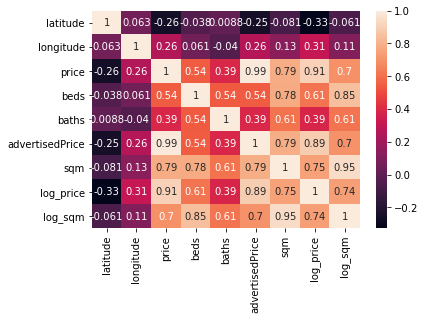

In [94]:
df_dub = df[df['county']=='Dublin']
corrMatrix = df_dub[df_dub.columns[0:25]].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()
#interestingly (and as expected), within Dublin, longitude and latitude both correlate negatively with price
#(longitude is negative) i.e, the further east and south you go the higher the price

<AxesSubplot:xlabel='propertyDescription', ylabel='price'>

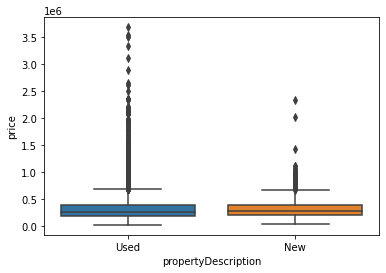

In [95]:
df = df.drop(df[df.propertyDescription == 'Teach/Árasán Cónaithe Atháimhe'].index)
df.groupby(['propertyDescription']).size()
df['propertyDescription'] = df['propertyDescription'].replace("New Dwelling house /Apartment", "New")
df['propertyDescription'] = df['propertyDescription'].replace("Second-Hand Dwelling house /Apartment", "Used")
sns.boxplot(x="propertyDescription", y="price", data=df)
# df_trim = df[df['price'] < 800000]
# sns.boxplot(x="propertyDescription", y="price", data=df_trim) #to see clearer without large outliers

<AxesSubplot:xlabel='propertyType', ylabel='price'>

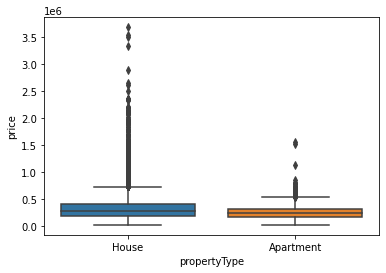

In [96]:
#same for house vs apartment
df.groupby(['propertyType']).size()
sns.boxplot(x="propertyType", y="price", data=df)

In [ ]:
##used this to reduce complexity in regression and Random Forest in R but it is not really worth using 
##the categorical locational (place names) features anyway 

##gather most common areas
#df.groupby(['area.1']).size().sort_values(ascending=False).head(53)
# area_counts = pd.DataFrame(df['area.1'].value_counts())
# area_counts.reset_index(level=0, inplace=True)
# area_counts = area_counts.rename(columns={"index": "Area", "area.1": "count"})
# uncommon_areas = area_counts['Area'][area_counts['count'] < 30]
# df['area.1'].replace(np.array(uncommon_areas), "Other", inplace=True) #replace fct removes need for a for loop here
# df['area.1'].value_counts().head()

# ##same for agencies

# agency_counts = pd.DataFrame(df['agency'].value_counts())
# agency_counts.reset_index(level=0, inplace=True)
# agency_counts = agency_counts.rename(columns={"index": "agency", "agency": "count"})
# uncommon_agencies = agency_counts['agency'][agency_counts['count'] < 35]
# df['agency'].replace(np.array(uncommon_agencies), "Other", inplace=True) #replace fct removes need for a for loop here
# df['agency'].value_counts().head()

# #same for neighborhoods
# neighborhood_counts = pd.DataFrame(df['neighborhood'].value_counts())
# neighborhood_counts.reset_index(level=0, inplace=True)
# neighborhood_counts = neighborhood_counts.rename(columns={"index": "neighborhood", "neighborhood": "count"})
# uncommon_neighborhoods = neighborhood_counts['neighborhood'][neighborhood_counts['count'] < 25]
# df['neighborhood'].replace(np.array(uncommon_neighborhoods), "Other", inplace=True) #replace fct removes need for a for loop here
# df['neighborhood'].value_counts().head()

# #same for streets
# street_counts = pd.DataFrame(df['street'].value_counts())
# street_counts.reset_index(level=0, inplace=True)
# street_counts = street_counts.rename(columns={"index": "street", "street": "count"})
# uncommon_streets = street_counts['street'][street_counts['count'] < 10]
# df['street'].replace(np.array(uncommon_streets), "Other", inplace=True) #replace fct removes need for a for loop here
# df['street'].value_counts().head()
# df['agency'].value_counts().head(60)

In [97]:
#distance to nearest school
import sklearn.neighbors

schools = pd.read_csv('Documents/Thesis/schools.csv',encoding='latin1')

#convert to radians for sklearn
df[['latitude_rad','longitude_rad']] = (np.radians(df.loc[:,['latitude','longitude']]))
schools[['Latitude_rad','Longitude_rad']] = (np.radians(schools.loc[:,['Latitude','Longitude']]))


#create distance matrix
dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')
dist_matrix = (dist.pairwise(df[['latitude_rad','longitude_rad']],schools[['Latitude_rad','Longitude_rad']])*6367)
# Note that 6367 is the radius of the earth in km
df_dist_matrix = (pd.DataFrame(dist_matrix,index=df.index, columns=schools['Address']))
df['dist_to_school'] = df_dist_matrix.min(axis=1)

In [98]:
#distance to nearest blue flag beache
beaches = pd.read_csv('Documents/Thesis/Beaches.csv')
beaches[['Latitude_rad','Longitude_rad']] = (np.radians(beaches.loc[:,['Latitude','Longitude']]))

#create distance matrix
dist_matrix_beach = (dist.pairwise(df[['latitude_rad','longitude_rad']],beaches[['Latitude_rad','Longitude_rad']])*6367)
# Note that 6367 is the radius of the earth in km
df_dist_matrix_beach = (pd.DataFrame(dist_matrix_beach,index=df.index, columns=beaches['Name']))
df['dist_to_beach'] = df_dist_matrix_beach.min(axis=1)

In [99]:
#remove 0 values for log transform 
df['dist_to_school'] = df['dist_to_school'].replace(0, .001)
df['duration'] = df['duration'].replace(0, 1)

#create dummy variable for house vs apartment
df['House'] = pd.get_dummies(df['propertyType'], drop_first=True)

In [100]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

dflog = df
logcolumns = ['price','beds', 'baths', 'sqm', 'duration','dist_to_beach', 'dist_to_school']
dflog.loc[:, logcolumns] = np.log(df[logcolumns])

# leaving out categorical area variables.. can use these but they add lots of complexity 
#and little information. Easier to see in R where you dont have to use so many dummy variables

X = dflog[['beds', 'baths', 'sqm', 'duration','dist_to_beach', 'dist_to_school']]
y = dflog['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    m_ape = mape(np.exp(true), np.exp(predicted))
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))    
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('MAPE:', m_ape)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    m_ape = mape(np.exp(true), np.exp(predicted))
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, m_ape, rmse, r2_square

In [102]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)
print(lin_reg.intercept_)
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

12.46057090982561


,Coefficient
beds,-0.057738
baths,0.004643
sqm,0.339626
duration,0.061162
dist_to_beach,-0.264287
dist_to_school,-0.058673


In [103]:
#LM model as expected is poor as it struggles to capture locational aspect without passing in thousands of categorical 
#area attributes (did this in R version since it's easier to see as you dont have to create dummmy variables but
#it is not efficient or effective)
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

#cross_val(lin_reg)
#lin reg is pretty poor

Test set evaluation:
_____________________________________
MAE: 0.39719724055478517
MSE: 0.2579147574066252
MAPE: 47.362593356520215
RMSE: 0.5078530864399912
R2 Square 0.3515331462048267
Train set evaluation:
_____________________________________
MAE: 0.3921876854071965
MSE: 0.2540373416189378
MAPE: 46.372982958366364
RMSE: 0.5040211717963223
R2 Square 0.3756985350335307


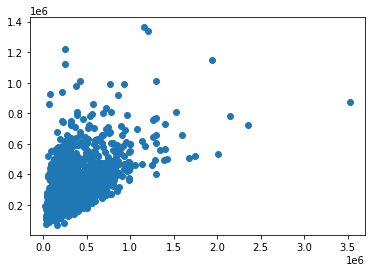

In [104]:
pred = lin_reg.predict(X_test)
plt.scatter(np.exp(y_test), np.exp(pred))

18383.580705436354


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


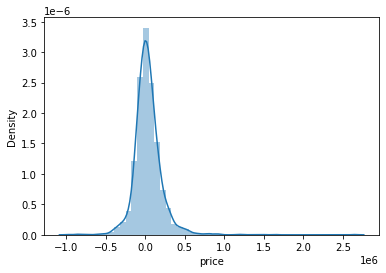

In [105]:
print(np.median(np.exp(y_test) - np.exp(pred)))
#median residual is ~21k 

#distribution of residuals 
sns.distplot((np.exp(y_test) - np.exp(pred)), bins=50);

In [106]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
X = df[['beds', 'baths', 'log_sqm', 'duration', 'dist_to_beach', 'dist_to_school', 'longitude', 'latitude', 'House']]
y = df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(n_estimators=300, random_state=0)
regressor.fit(X_train, y_train)
regressor.score(X_train, y_train)

#predict y values on test set 
y_pred_rf = regressor.predict(X_test)

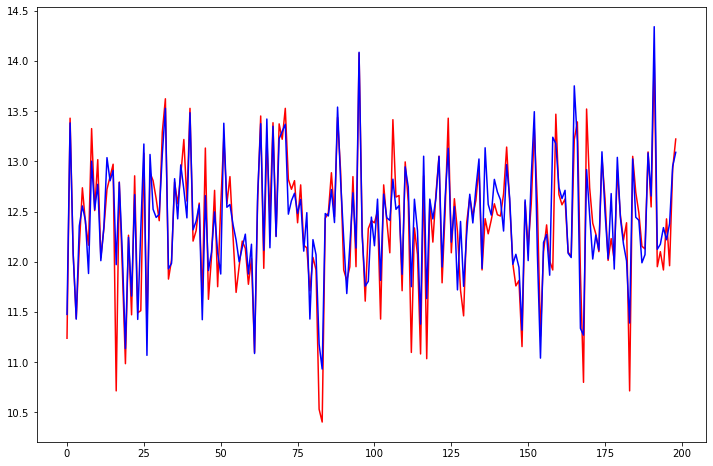

In [107]:
# Plot y_test vs y_pred for first 200 points 
plt.figure(figsize=(12,8))
plt.plot(np.array(y_test)[1:200], color='red')
plt.plot(y_pred_rf[1:200], color='blue')
plt.show()

<ipython-input-108-6077d46effc6>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


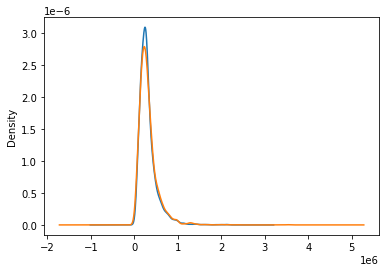

In [108]:
#plot densities 
pred_df_rf = pd.DataFrame()
pred_df_rf['y_pred'] = np.exp(y_pred_rf)
pred_df_rf['y_test'] = np.exp(np.array(y_test))

fig, ax = plt.subplots(1,1)
for s in pred_df_rf.columns:
    pred_df_rf[s].plot(kind='density')
fig.show()

Test set evaluation:
_____________________________________
MAE: 0.16452031973784992
MSE: 0.05364983101417001
MAPE: 17.291825092033235
RMSE: 0.23162433165401689
R2 Square 0.8651099399110698
2774.376081702474


<AxesSubplot:xlabel='y_test', ylabel='y_pred'>

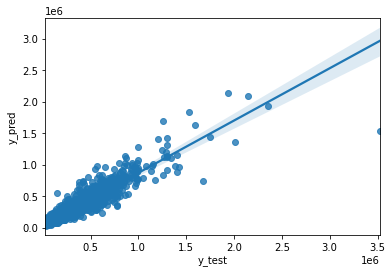

In [109]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, y_pred_rf)
# print(cross_val(regressor))

print(np.median(np.exp(y_test) - np.exp(y_pred_rf)))
#median residual is ~2.5k 

sns.regplot(x=pred_df_rf['y_test'], y=pred_df_rf['y_pred'])
#much better because it can use locational feature as primary source of info (rather than long factor list of areas)

Text(0.5, 0, 'Random Forest Feature Importance')

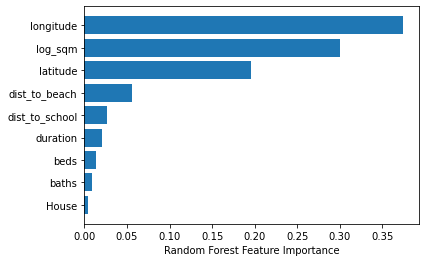

In [110]:
#plot feature importance 
importance = regressor.feature_importances_
sorted_idx = regressor.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], regressor.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
#longitude (east/west) is a better predictor than latitude #north south

Text(0.5, 0, 'Random Forest Feature Importance')

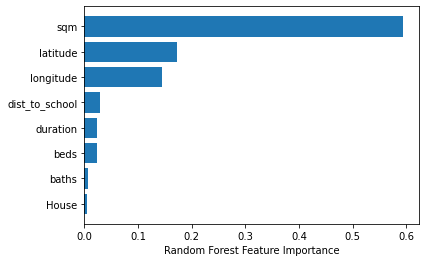

In [111]:
#show the same result for dublin
df_dub = df[df['county']=='Dublin']

from sklearn.ensemble import RandomForestRegressor
X_dub = df_dub[['beds', 'baths', 'sqm', 'duration', 'dist_to_school', 'longitude', 'latitude', 'House']]
y_dub = df_dub['price']

X_train_dub, X_test_dub, y_train_dub, y_test_dub = train_test_split(X_dub, y_dub, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(n_estimators=300, random_state=0)
regressor.fit(X_train_dub, y_train_dub)
regressor.score(X_train_dub, y_train_dub)

#predict y values on test set 
y_pred_dub = regressor.predict(X_test_dub)

#plot feature importance 
importance = regressor.feature_importances_
sorted_idx = regressor.feature_importances_.argsort()
plt.barh(X_dub.columns[sorted_idx], regressor.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# within dublin latitude (north/south) is a better predictor than longitude (east/west)
# (after removing dist to beach since this is essentially longitude in dub)

In [ ]:
##XGB model
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

#hyperparameter searching
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 1200), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)

#show hyperparameters for highest ranking xgb result 
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
        
report_best_scores(search.cv_results_, 1)

In [113]:
#using above parameters.. lots of trees helps most
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, n_estimators=796
                             ,subsample=0.83, 
                            colsample_bytree=0.72, gamma=0.044, learning_rate=0.04, max_depth=5)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
pred_df_xgb = pd.DataFrame()
pred_df_xgb['y_pred'] = np.exp(y_pred_xgb)
pred_df_xgb['y_test'] = np.exp(np.array(y_test))

print_evaluate(y_test, y_pred_xgb)
# print(cross_val(xgb_model))

MAE: 0.16594806177291535
MSE: 0.052361326084673525
MAPE: 17.32792436553194
RMSE: 0.2288259733611408
R2 Square 0.8683495867856099


Text(0.5, 0, 'XGB Feature Importance')

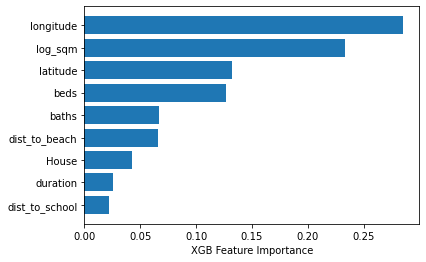

In [114]:
#plot feature importance 
importance = xgb_model.feature_importances_
sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel("XGB Feature Importance")

#Features like is house/apartment are much more important in the XGB model than in RF

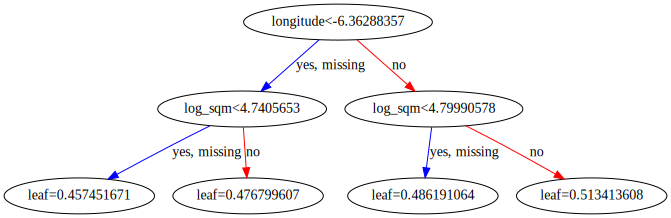

In [115]:
# requires graphviz and python-graphviz conda packages
import graphviz

#xgb.plot_importance(xgb_model) #(based on Fscore)

#plot the output tree via matplotlib, specifying the ordinal number of the target tree
#xgb.plot_tree(xgb_model, num_trees=20)

# converts the target tree to a graphviz instance
xgb.to_graphviz(xgb_model)


In [ ]:
#need to run this in notebook as well as brew install
#!pip install lightgbm

In [116]:
#Same for Light GBM
import lightgbm as lgb
gbm_model = lgb.LGBMRegressor()
gbm_model.fit(X_train, y_train)
y_pred_gbm = gbm_model.predict(X_test)

pred_df_gbm = pd.DataFrame()
pred_df_gbm['y_pred'] = np.exp(y_pred_gbm)
pred_df_gbm['y_test'] = np.exp(np.array(y_test))

print_evaluate(y_test, y_pred_gbm)
# print(cross_val(xgb_model))

MAE: 0.17121022783102421
MSE: 0.055153655200903234
MAPE: 17.93127383524533
RMSE: 0.23484815349689941
R2 Square 0.8613289226911263


In [117]:
#weight predictions by RMSE (do this for other models also.. cubist/xgb lin/ada, etc)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb))
rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))
rmse_gbm = np.sqrt(metrics.mean_squared_error(y_test, y_pred_gbm))

weight_xgb = (1/rmse_xgb)/(1/rmse_xgb + 1/rmse_rf + 1/rmse_gbm)
weight_rf = (1/rmse_rf)/(1/rmse_xgb + 1/rmse_rf + 1/rmse_gbm)
weight_gbm = (1/rmse_gbm)/(1/rmse_xgb + 1/rmse_rf + 1/rmse_gbm)

stacked_pred = (weight_xgb * y_pred_xgb) + (weight_rf * y_pred_rf) + (weight_gbm * y_pred_gbm)
#stacked model has lowest MAPE and RMSE of any of the individual tree models 
print_evaluate(y_test, stacked_pred)

MAE: 0.1625791366188434
MSE: 0.05094151157170498
MAPE: 17.02452643937869
RMSE: 0.22570226310718502
R2 Square 0.8719193811605237
